## Quora Kaggle competition

Welcome to the Quora Question Pairs competition! Here, our goal is to identify which questions asked on Quora, a quasi-forum website with over 100 million visitors a month, are duplicates of questions that have already been asked. This could be useful, for example, to instantly provide answers to questions that have already been answered. We are tasked with predicting whether a pair of questions are duplicates or not, and submitting a binary prediction against the logloss metric.

In [54]:
import numpy as np
import pandas as pd
import os,re
import cPickle
import seaborn as sns
import gensim as gn
import logging
from nltk.stem.porter import PorterStemmer
from gensim import corpora, models
from gensim.models.word2vec import Word2Vec
import nltk
import scipy.sparse as sparse
from nltk.data import load
from fuzzywuzzy import fuzz
from sklearn import linear_model
from sklearn.manifold import TSNE
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
import matplotlib.pyplot as plt
from sklearn.cross_validation import cross_val_score
import pyLDAvis.gensim as gensimvis
import pyLDAvis
import xgboost as xgb
from tqdm import tqdm
from pyemd import emd
from scipy.spatial.distance import cosine, cityblock, jaccard, canberra, euclidean, minkowski, braycurtis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
%matplotlib inline
#logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
pd.set_option('display.max_columns', 200)

### Training data

In [2]:
df_train = pd.read_csv('./data/train.csv',nrows=1000)
df_test = pd.read_csv('./data/test.csv',nrows=1000)
df_train.head(3)

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0


In [3]:
print('Total number of question pairs for training: {}'.format(len(df_train)))
print('Total number of question pairs for test data: {}'.format(len(df_test)))
print('Duplicate pairs : {} %'.format(round(df_train['is_duplicate'].mean()*100,2)))

Total number of question pairs for training: 1000
Total number of question pairs for test data: 1000
Duplicate pairs : 38.0 %


## Generate features

### Text handcrafted features (fs_1)

In [4]:
def generate_features(df_train):
    df_train['len_q1'] = df_train['question1'].apply(lambda x:len(str(x)))
    df_train['len_q2'] = df_train['question2'].apply(lambda x:len(str(x)))
    df_train['diff_len'] = df_train.len_q1-df_train.len_q2
    df_train['len_char_q1'] = df_train.question1.apply(lambda x:len(''.join(set(str(x).replace(' ','')))))
    df_train['len_char_q2'] = df_train.question2.apply(lambda x:len(''.join(set(str(x).replace(' ','')))))
    df_train['len_word_q1'] = df_train.question1.apply(lambda x:len(str(x).split()))
    df_train['len_word_q2'] = df_train.question2.apply(lambda x:len(str(x).split()))
    df_train['common_words'] = df_train.apply(lambda x:len(set(str(x['question1']).lower().split()).intersection(set(str(x['question2']).lower().split()))),axis=1)

    df_train['fuzzy_qratio'] = df_train.apply(lambda x: fuzz.QRatio(str(x['question1']),str(x['question2'])),axis=1)
    df_train['fuzzy_wratio'] = df_train.apply(lambda x:fuzz.WRatio(str(x['question1']),str(x['question2'])),axis=1)
    df_train['fuzzy_partial_ratio'] = df_train.apply(lambda x:fuzz.partial_ratio(str(x['question1']),str(x['question2'])),axis=1)
    df_train['fuzzy_partial_token_set_ratio'] = df_train.apply(lambda x:fuzz.partial_token_set_ratio(str(x['question1']),str(x['question2'])),axis=1)
    df_train['fuzzy_partial_token_sort_ratio'] = df_train.apply(lambda x:fuzz.partial_token_sort_ratio(str(x['question1']),str(x['question2'])),axis=1)
    df_train['fuzzy_token_sort_ratio'] = df_train.apply(lambda x:fuzz.token_sort_ratio(str(x['question1']),str(x['question2'])),axis=1)
    df_train['fuzzy_token_set_ratio'] = df_train.apply(lambda x:fuzz.token_set_ratio(str(x['question1']),str(x['question2'])),axis=1)
    return df_train

In [5]:
df_train = generate_features(df_train)
df_test = generate_features(df_test)
df_train.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,len_word_q1,len_word_q2,common_words,fuzzy_qratio,fuzzy_wratio,fuzzy_partial_ratio,fuzzy_partial_token_set_ratio,fuzzy_partial_token_sort_ratio,fuzzy_token_sort_ratio,fuzzy_token_set_ratio
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,9,20,20,14,12,10,93,95,98,100,88,93,100
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,-37,21,29,8,13,4,66,86,73,100,73,63,86
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,25,24,14,10,4,43,60,41,100,71,63,63


### LDA (Lattent Dirichlet Allocation) features 

In [6]:
# Steaming 
p_stemmer = PorterStemmer()
STOP_WORDS = nltk.corpus.stopwords.words()

def clean_sentence(val):
    "remove chars that are not letters or numbers, downcase, then remove stop words"
    regex = re.compile('([^\s\w]|_)+')
    sentence = regex.sub('', val).lower()
    sentence = sentence.split(" ")
    
    for word in list(sentence):
        if word in STOP_WORDS:
            sentence.remove(word)  
            
    sentence = " ".join(sentence)
    return sentence

def clean_dataframe(data):
    "drop nans, then apply 'clean_sentence' function to question1 and 2"
    data = data.dropna(how="any")
    
    for col in ['question1', 'question2']:
        data[col] = data[col].apply(clean_sentence)
    
    return data

# Function to vuild a corpus
def build_corpus(data):
    "Creates a list of lists containing words from each sentence"
    corpus = []
    for col in ['question1', 'question2']:
        for sentence in data[col].iteritems():
            word_list = sentence[1].split(" ")
            corpus.append(word_list)
    return corpus

In [7]:
data = clean_dataframe(df_train)
corpus = build_corpus(data)
dictionary = corpora.Dictionary(corpus)
corpus = [dictionary.doc2bow(text) for text in corpus]
ldamodel = models.ldamodel.LdaModel(corpus, num_topics=100, id2word = dictionary)

In [8]:
def common_lda_topic(sentence1,sentence2,dictionary,ldamodel,min_proba):
    "find #common topic based on lattent dirichlet allocation model"
    sentence1 = sentence1.split()
    sentence2 = sentence2.split()

    sentence1 = dictionary.doc2bow(sentence1)
    sentence2 = dictionary.doc2bow(sentence2)
    
    topic_a = ldamodel.get_document_topics(sentence1,minimum_probability=min_proba)
    topic_b = ldamodel.get_document_topics(sentence2,minimum_probability=min_proba)
    
    topic_a = list(sorted(topic_a, key=lambda x: x[1]))
    topic_b = list(sorted(topic_b, key=lambda x: x[1]))
    common_topic = set([x[0] for x in topic_a]).intersection(x[0] for x in topic_b)
    return(len(common_topic))

In [9]:
#vis_data = gensimvis.prepare(ldamodel, corpus, dictionary)
#pyLDAvis.display(vis_data)

In [10]:
df_train['common_topics'] = df_train.apply(lambda x:common_lda_topic(str(x['question1']),str(x['question2']),dictionary,ldamodel,0.1),axis=1)
df_test['common_topics'] = df_test.apply(lambda x:common_lda_topic(str(x['question1']),str(x['question2']),dictionary,ldamodel,0.1),axis=1)

### POS-Tagging features

In [11]:
def common_pos_tagging(question1,question2):
    question1 = nltk.word_tokenize(question1)
    question2 = nltk.word_tokenize(question2)
    pos_question1 = nltk.pos_tag(question1)
    pos_question2 = nltk.pos_tag(question2)

    pos_1_array = [x[1] for x in pos_question1]
    pos_2_array = [x[1] for x in pos_question2]
    return(len(set(pos_1_array).intersection(pos_2_array)))

In [12]:
def count_distinct_pos_tagging(df_train):
    #Generate all pos-tag null columns
    tagdict = load('help/tagsets/upenn_tagset.pickle')
    pos_tag = tagdict.keys()
    for tag in pos_tag:
        df_train[tag+"_q1"] = 0
        df_train[tag+"_q2"] = 0
        
    for index, row in df_train.iterrows():
        question1 = row.question1.decode('utf-8')
        question1 = nltk.word_tokenize(question1)

        question2 = row.question2.decode('utf-8')
        question2 = nltk.word_tokenize(question2)

        pos_question1 = nltk.pos_tag(question1)
        pos_question1 = [x[1] for x in pos_question1]

        pos_question2 = nltk.pos_tag(question2)
        pos_question2 = [x[1] for x in pos_question2]

        for tag in pos_question1:
            if(tag != "#"):
                df_train.set_value(index,tag+"_q1",row[tag+"_q1"]+1)

        for tag in pos_question2:
            if(tag != "#"):
                df_train.set_value(index,tag+"_q2",row[tag+"_q2"]+1)

In [13]:
df_train['common_pos_count'] = df_train.apply(lambda x:common_pos_tagging(str(x['question1']).decode('utf-8'),str(x['question2']).decode('utf-8')),axis=1)
df_test['common_pos_count'] = df_test.apply(lambda x:common_pos_tagging(str(x['question1']).decode('utf-8'),str(x['question2']).decode('utf-8')),axis=1)
count_distinct_pos_tagging(df_train)
count_distinct_pos_tagging(df_test)

In [14]:
df_train.head(3)

,id,qid1,qid2,question1,question2,is_duplicate,len_q1,len_q2,diff_len,len_char_q1,len_char_q2,len_word_q1,len_word_q2,common_words,fuzzy_qratio,fuzzy_wratio,fuzzy_partial_ratio,fuzzy_partial_token_set_ratio,fuzzy_partial_token_sort_ratio,fuzzy_token_sort_ratio,fuzzy_token_set_ratio,common_topics,common_pos_count,PRP$_q1,PRP$_q2,VBG_q1,VBG_q2,VBD_q1,VBD_q2,``_q1,``_q2,VBN_q1,VBN_q2,",_q1",",_q2",''_q1,''_q2,VBP_q1,VBP_q2,WDT_q1,WDT_q2,JJ_q1,JJ_q2,WP_q1,WP_q2,VBZ_q1,VBZ_q2,DT_q1,DT_q2,RP_q1,RP_q2,$_q1,$_q2,NN_q1,NN_q2,)_q1,)_q2,(_q1,(_q2,FW_q1,FW_q2,POS_q1,POS_q2,._q1,._q2,TO_q1,TO_q2,LS_q1,LS_q2,RB_q1,RB_q2,:_q1,:_q2,NNS_q1,NNS_q2,NNP_q1,NNP_q2,VB_q1,VB_q2,WRB_q1,WRB_q2,CC_q1,CC_q2,PDT_q1,PDT_q2,RBS_q1,RBS_q2,RBR_q1,RBR_q2,CD_q1,CD_q2,PRP_q1,PRP_q2,EX_q1,EX_q2,IN_q1,IN_q2,WP$_q1,WP$_q2,MD_q1,MD_q2,NNPS_q1,NNPS_q2,--_q1,--_q2,JJS_q1,JJS_q2,JJR_q1,JJR_q2,SYM_q1,SYM_q2,UH_q1,UH_q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,66,57,9,20,20,14,12,10,93,95,98,100,88,93,100,1,9,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,1,1,0,0,1,1,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,51,88,-37,21,29,8,13,4,66,86,73,100,73,63,86,0,8,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,0,1,1,0,0,0,0,1,1,1,1,1,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,73,59,14,25,24,14,10,4,43,60,41,100,71,63,63,0,8,1,0,1,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0


# Word2vec features 
Word2Vec creates a multi-dimensional vector for every word in the english vocabulary (or the corpus it has been trained on). Word2Vec embeddings are very popular in natural language processing and always provide us with great insights. Wikipedia provides a good explanation of what these embeddings are and how they are generated (https://en.wikipedia.org/wiki/Word2vec).

In [15]:
model = gn.models.KeyedVectors.load_word2vec_format('./data/GoogleNews-vectors-negative300.bin', binary=True)
model.init_sims(replace=True)

In [16]:
print("Word2vec mean of president : {} mean of obama {}".format(model['president'].mean(),model['king'].mean()))

Word2vec mean of president : 0.00630775932223 mean of obama 0.00169826287311


The idea here is to build a vector of each word in differents sentences (question1, question2), each word will be presented in a 300 dimensions vector. So we will try to calculate the average of these vector in order to compare the result obtained in the first and second question. I will try to calculate differents distances based on theses vectors such as euclidiant distance, cosine similiratity, hamming distance ... and generate some features based on semantic of words. So, if sentence $s1$ contains $K$ words, we can present this sentence by $K$ arrays of $300$ dimensions. So a matrix of $[K*300]$.

An example of the application of this model is to find the word the most similar to a particular word (semantic sense I mean). Lets try to find the most similar word to `Obama`.

In [17]:
model.most_similar(positive=["Obama"])

[(u'Barack_Obama', 0.8036513328552246),
 (u'President_Barack_Obama', 0.7878769040107727),
 (u'McCain', 0.7555227279663086),
 (u'Clinton', 0.7526832818984985),
 (u'Illinois_senator', 0.74974524974823),
 (u'Biden', 0.7485178709030151),
 (u'Bush', 0.7348896265029907),
 (u'Barack', 0.7290467023849487),
 (u'White_House', 0.7151209115982056),
 (u'elect_Barack_Obama', 0.6941337585449219)]

In [18]:
def sent2vec(s):
    words = str(s).lower().decode('utf-8')
    words = nltk.word_tokenize(words)
    words = [w for w in words if not w in STOP_WORDS]
    words = [w for w in words if w.isalpha()]
    M = []
    for w in words:
        try:
            M.append(model[w])
        except:
            continue
    M = np.array(M)
    return M

We will take now an example of a sentence and apply the word2vec model of words that contains, Lets take the first observation of the train dataframe. It's `'What is the step by step guide to invest in share market in india?'`, so this sentences contains 7 words (after deleting stop words). So this sentence will be presented by a $[7*300]$ matrix. Let's do that

In [19]:
m = sent2vec(df_train.iloc[0].question1)
print("The sentences vectors {}, the shape of this vector is : {}".format(m,m.shape))

The sentences vectors [[-0.07852414  0.04130891  0.04205321 ...,  0.11536722  0.02307344
  -0.00869906]
 [-0.07852414  0.04130891  0.04205321 ...,  0.11536722  0.02307344
  -0.00869906]
 [ 0.01465341 -0.00877338 -0.0530136  ..., -0.01913343  0.06570699
   0.05861362]
 ..., 
 [-0.02046456 -0.02115659 -0.04092911 ..., -0.03796323 -0.0039545
  -0.08660363]
 [-0.06247045 -0.03513963 -0.09175348 ...,  0.05661384  0.01893635
  -0.00541736]
 [-0.0631949  -0.01935344  0.00284706 ..., -0.02567293 -0.03133414
  -0.03028089]], the shape of this vector is : (7, 300)


The disadvantage of the `word2vec` model that we can't present all the sentence but only words, so we will try some metodologies to present all the sentence using the `word2vec` model, we will for example try to sum the `word2vec` array and calculate the distance between the 2 questions. So each question will be presented using a ${R}^{300}$ vector, and calculate the distance between two ${R}^{300}$ vectors

In [20]:
model.most_similar(positive=["Obama"])

[(u'Barack_Obama', 0.8036513328552246),
 (u'President_Barack_Obama', 0.7878769040107727),
 (u'McCain', 0.7555227279663086),
 (u'Clinton', 0.7526832818984985),
 (u'Illinois_senator', 0.74974524974823),
 (u'Biden', 0.7485178709030151),
 (u'Bush', 0.7348896265029907),
 (u'Barack', 0.7290467023849487),
 (u'White_House', 0.7151209115982056),
 (u'elect_Barack_Obama', 0.6941337585449219)]

### Word mover's distance feature : 
In document classification and other natural language processing applications, having a good measure of the similarity of two texts can be a valuable building block. Ideally, such a measure would capture semantic information. Cosine similarity on bag-of-words vectors is known to do well in practice, but it inherently cannot capture when documents say the same thing in completely different words. Take, for example, two headlines:

<b>`- Obama speaks to the media in Illinois`</b>

<b>`- The President greets the press in Chicago`</b>

These have no content words in common, so according to most bag of words—based metrics, their distance would be maximal. (For such applications, you probably don’t want to count stopwords such as the and in, which don’t truly signal semantic similarity.)


The distance between two texts is given by the total amount of “mass” needed to move the words from one side into the other, multiplied by the distance the words need to move. So, starting from a measure of the distance between different words, we can get a principled document-level distance.

In [33]:
def wmd(s1,s2):
    s1 = str(s1).lower().decode('utf-8').split()
    s2 = str(s2).lower().decode('utf-8').split()
    s1 = [w for w in s1 if w not in STOP_WORDS]
    s2 = [w for w in s2 if w not in STOP_WORDS]
    return model.wmdistance(s1,s2)

In [24]:
df_train['wmd'] = df_train.apply(lambda x:model.wmdistance(x['question1'],x['question2']),axis=1)
df_test['wmd'] = df_test.apply(lambda x:model.wmdistance(x['question1'],x['question2']),axis=1)

In [32]:
df_train.wmd.describe()

count    1000.000000
mean        0.268004
std         0.125539
min         0.000000
25%         0.186729
50%         0.257678
75%         0.330898
max         1.105248
Name: wmd, dtype: float64

### Calculcate differents distances (euclidian, cosine, jaccard, monkowski ...)
We will try now to calculate the distance between two questions. i.e between the two ${R}^{300}$ vector, so we will present these two vector as 2 points in a plan of $300$ dimensions, and calculate the distance between those points. Let's do that

In [39]:
def word2vec_sentences(s):
    M = sent2vec(s)
    v = M.sum(axis=0)
    return v / np.sqrt((v ** 2).sum())

In [66]:
# Array contains the word2vec sum (sentences)
question1_vectors = np.zeros((df_train.shape[0], 300))
question2_vectors = np.zeros((df_train.shape[0], 300))

question1_test_vectors = np.zeros((df_train.shape[0], 300))
question2_test_vectors = np.zeros((df_train.shape[0], 300))
for i, q in tqdm(enumerate(df_train.question1.values)):
    question1_vectors[i, :] = word2vec_sentences(q)

for i,q in tqdm(enumerate(df_train.question2.values)):
    question2_vectors[i, :] = word2vec_sentences(q)
    
for i, q in tqdm(enumerate(df_test.question1.values)):
    question1_test_vectors[i, :] = word2vec_sentences(q)

for i,q in tqdm(enumerate(df_test.question2.values)):
    question2_test_vectors[i, :] = word2vec_sentences(q)

159it [00:00, 1581.79it/s]/Users/aissaelouafi/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:4: RuntimeWarning: invalid value encountered in double_scalars
1000it [00:00, 1736.90it/s]
1000it [00:00, 1778.51it/s]
1000it [00:00, 1723.37it/s]
1000it [00:00, 1683.48it/s]


In [98]:
df_train['cosine_distance'] = [cosine(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors),np.nan_to_num(question2_vectors))]
df_train['euclidean_distance'] = [euclidean(x, y) for(x, y) in zip(np.nan_to_num(question1_vectors),np.nan_to_num(question2_vectors))]

df_test['cosine_distance'] = [cosine(x, y) for (x, y) in zip(np.nan_to_num(question1_test_vectors),np.nan_to_num(question2_test_vectors))]
df_test['euclidean_distance'] = [euclidean(x, y) for(x, y) in zip(np.nan_to_num(question1_test_vectors),np.nan_to_num(question2_test_vectors))]


df_train['jaccard_distance'] = [jaccard(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors),np.nan_to_num(question2_vectors))]
df_test['jaccard_distance'] = [jaccard(x, y) for(x, y) in zip(np.nan_to_num(question1_test_vectors),np.nan_to_num(question2_test_vectors))]


df_train['canberra_distance'] = [canberra(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors),np.nan_to_num(question2_vectors))]
df_test['canberra_distance'] = [canberra(x, y) for(x, y) in zip(np.nan_to_num(question1_test_vectors),np.nan_to_num(question2_test_vectors))]


df_train['minkowski_distance'] = [minkowski(x, y, 3) for (x, y) in zip(np.nan_to_num(question1_vectors),np.nan_to_num(question2_vectors))]
df_test['minkowski_distance'] = [minkowski(x, y, 3) for(x, y) in zip(np.nan_to_num(question1_test_vectors),np.nan_to_num(question2_test_vectors))]


df_train['braycurtis_distance'] = [braycurtis(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors),np.nan_to_num(question2_vectors))]
df_test['braycurtis_distance'] = [braycurtis(x, y) for(x, y) in zip(np.nan_to_num(question1_test_vectors),np.nan_to_num(question2_test_vectors))]


df_train['canberra_distance'] = [canberra(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors),np.nan_to_num(question2_vectors))]
df_test['canberra_distance'] = [canberra(x, y) for(x, y) in zip(np.nan_to_num(question1_test_vectors),np.nan_to_num(question2_test_vectors))]


df_train['cityblock_distance'] = [cityblock(x, y) for (x, y) in zip(np.nan_to_num(question1_vectors),np.nan_to_num(question2_vectors))]
df_test['cityblock_distance'] = [cityblock(x, y) for(x, y) in zip(np.nan_to_num(question1_test_vectors),np.nan_to_num(question2_test_vectors))]

In [99]:
df_train.euclidean_distance.describe()

count    1000.000000
mean        0.671730
std         0.317851
min         0.000000
25%         0.494646
50%         0.687001
75%         0.876886
max         1.362603
Name: euclidean_distance, dtype: float64

## Extract features important with ExtraTreesClassifier
LDA is a supervised stastical technique to reduce dimensions

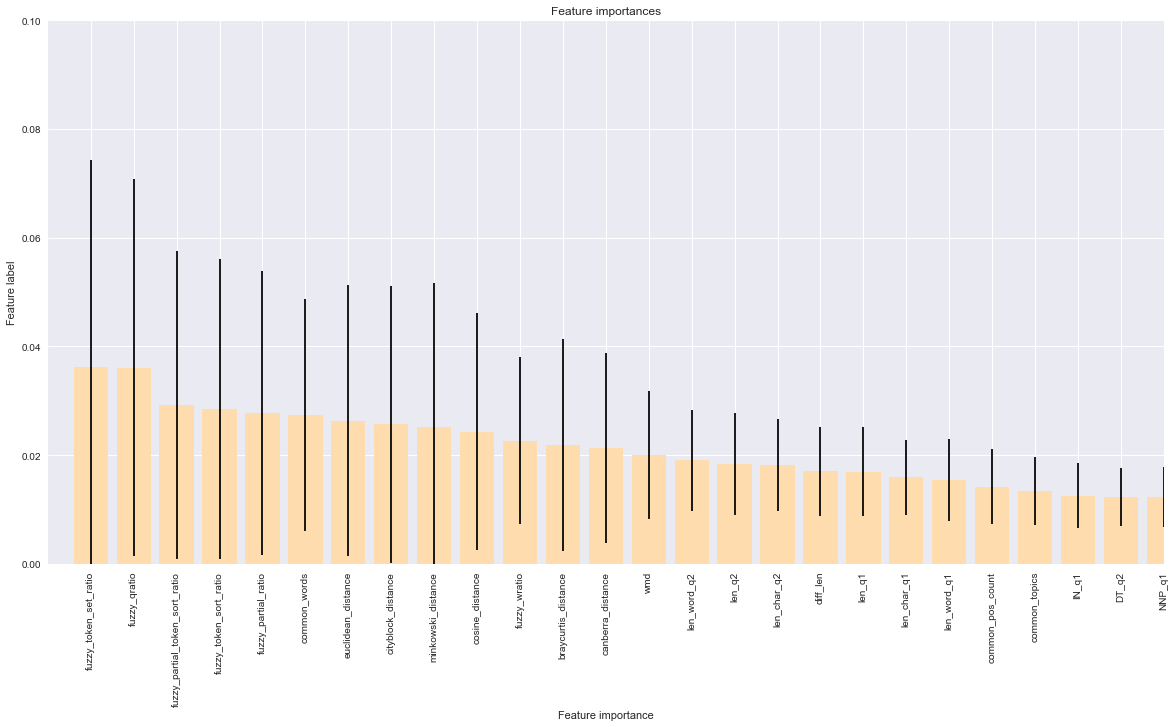

In [100]:
# Build a forest and compute the feature importances
forest = ExtraTreesClassifier(n_estimators=250,random_state=0)
train = df_train.ix[:, 6:,]
train = train.fillna(0)
forest.fit(train, df_train.is_duplicate)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
indices = np.argsort(importances)[::-1]
list = train.columns.values
# Print the feature ranking
#print("Feature ranking:")

#for f in range(train.shape[1]):
#    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure(figsize=(20, 10))
plt.title("Feature importances")
plt.bar(range(train.shape[1]), importances[indices],color='#ffdcad', yerr=std[indices], align="center")
plt.xticks(range(train.shape[1]), list[indices],rotation='vertical')
plt.xlim([-1, 25])
plt.ylim([0,.1])
plt.xlabel("Feature importance")
plt.ylabel("Feature label")
plt.show()

## Logistic Regression 

In [101]:
logreg = linear_model.LogisticRegression(C=1e5)
X = df_train.ix[:, 6:,]
X = X.fillna(0)
Y = df_train.is_duplicate

In [102]:
print('Train shape : {}, Test shape : {}'.format(X.shape,df_test.ix[:, 3:,].shape))

Train shape : (1000, 115), Test shape : (1000, 115)


In [103]:
logreg.fit(X, Y)

LogisticRegression(C=100000.0, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [104]:
df_test = df_test.fillna(0)
proba_replicated = logreg.predict_proba(df_test.ix[:, 3:,])
proba = proba_replicated[:,1]
len(proba)
sub = pd.DataFrame()
sub['test_id'] = df_test['test_id']
sub['is_duplicate'] = proba
sub.to_csv('simple_lr.csv', index=False)

### Log loss cross validation

In [118]:
scores = cross_val_score(logreg, X, Y, cv=5, scoring='accuracy')
scores.mean()

0.67599999999999993

## XGBOOST Model

In [116]:
# Set our parameters for xgboost
from sklearn.metrics import accuracy_score

params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

x_train = df_train.ix[:, 6:,]
y_train = df_train.is_duplicate

d_train = xgb.DMatrix(x_train, label=y_train)


bst = xgb.train(params, d_train, 400)

test = df_test.ix[:, 3:,]
d_test = xgb.DMatrix(test)
p_test = bst.predict(d_test)

predictions = [round(value) for value in p_test]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

NameError: name 'y_test' is not defined

### Create submission file

In [325]:
text = nltk.word_tokenize("And now for something completely different")
nltk.pos_tag(text)

[('And', 'CC'),
 ('now', 'RB'),
 ('for', 'IN'),
 ('something', 'NN'),
 ('completely', 'RB'),
 ('different', 'JJ')]